# SEVIR Tutorial

The Storm EVent ImagRy (SEVIR) dataset is a collection of temporally and spatially aligned public datasets collected and distributed by NOAA. This tutorial provides information about the SEVIR dataset as well as sample code that accesses the data.

This animations shows one of thousands of samples avaialbe in the SEVIR dataset.   Each sample consists of 4 hours of data in 5 minute steps over a  384 km x 384 km patch sampled somewhere over the continential US:

<p>
    <center><img src="tutorial_img/sevir_sample.gif" alt="sev_samp"/>
    <center><em>Figure 1:  Sample event in the SEVIR dataset</em>
</p>


The tutorial contains the following 

* [SEVIR Overview](#overview)
* [Data organization](#files)
* [Accessing raster types](#rasters)
* [Accessing lightning](#lightning)
* [Additional resources](#additional)



## SEVIR Overview <a class="anchor" id="overview"></a>

The size and complexity of weather data can make it difficult to work with, especially for those who are non-experts in weather-realted datasets.  The SEVIR dataset was constructed to enable faster R&D in areas of weather sensing and short-term forecasting.  SEVIR combines and aligns multiple weather sensing modalities into a single accessible dataset that can be used by meterologists, data scientists and other researchers interested in enabling new capabilities.  

SEVIR is a collection of thousands of "events", which are 4-hour sequences of weather captured by up to 5 sensors.   These 5 sensing modalities are summarized in the table below:


| Sensor | Data key | Description | Spatial Resolution |  Patch Size |  Time step | Sample Colorized Image |
|:--------:|:------:|:-------------:|:--------------------:|:---------:|:-----------:|:------:|
|  GOES-16 C02 0.64 $\mu m$  |`vis`  |  Visible satellite imagry |  0.5 km | 768x768 | 5 minute   |      <img src="tutorial_img/vis_sample.png" width="80" height="80" />        |
|  GOES-16 C09 6.9 $\mu m$  |`ir069`   |  Infrared Satellite imagry (Water Vapor) | 2 km | 192 x 192  | 5 minutes         |     <img src="tutorial_img/ir069_sample.png" width="80" height="80" />        |
|  GOES-16 C13 10.7 $\mu m$  |`ir107`   |  Infrared Satellite imagry (Window) | 2 km | 192 x 192  | 5 minutes         |     <img src="tutorial_img/ir107_sample.png" width="80" height="80" />        |
|  Vertically Integrated Liquid (VIL) |`vil`   |  NEXRAD radar mosaic of VIL | 1 km | 384 x 384  | 5 minutes         |     <img src="tutorial_img/vil_sample.png" width="80" height="80" />        |
|  GOES-16 GLM flashs |`lght`   |  Detections of inter cloud and cloud to ground lightning events | 8 km | N/A  | Continuous   |     <img src="tutorial_img/lght_sample.png" width="80" height="80" />        |

<p>
    <center><em>Table 1:  Description of sensor types in SEVIR </em>
</p>

Four of the five sensor types listed above (`vis`,`ir069`,`ir107` & `vil`) are raster types.  Their data is repsented as a sequence of single channel (grey scale) images.  Each 4 hour event corresponding to these data types are represented as a `L x L x 49` tensor, where `L` is the image size given in the Patch Size column above.  The last dimension of length 49 represents the time dimension of the data, which is consistent acorss all samples.  Additional information on working with these images is given below.

The lightning type `lght` is not stored as an image, but rather as a collection of discrete events.  This lightning data for an event is represented by an `Nx5` matrix, that contains information about flash time and location.  Additional details are provided below.


### Connection to NOAA's Storm Event Database

Much of the data in SEVIR can augmented using data collected by the National Weather Service (NWS).  Approximately 20% of the cases in SEVIR were selected 
based on tagged "Storm Events" logged by the National Weather Service (NWS) which are archived here: https://www.ncdc.noaa.gov/stormevents/.  SEVIR events that overlap with logged NWS storm events can be augmented with the additional data contained in the NWS Storm event database.  This database includes addtional information including:

* Type of severe weather (e.g. high winds, tornado, hail, etc..)
* Storm impacts (damage, injuries and deaths)
* Narrative summarizing the event.

For example, here is one example entry from the NWS Storm Events database that is linked to the event depicted in Figure 1.  This represents one row from a CSV file whose columns are described [here](https://www1.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/Storm-Data-Export-Format.pdf)

```
StormEvents_details-ftp_v1.0_d2019_c20191217.csv:
201904,30,1452,201904,30,1454,137733,827433,"ILLINOIS",17,2019,"April","Tornado","C",135,"MONTGOMERY","LSX","30-APR-19 14:52:00","CST-6","30-APR-19 14:54:00","0","0","0","0","0.00K","0.00K","Storm Chaser",,,,,"EF0","1.17","25",,,,,"1","N","DONNELLSON","2","NE","DONNELLSON","39.0456","-89.4682","39.0517","-89.4478","As a warm front lifted northward through the region, widespread showers and thunderstorms developed. Some of the storms produced severe weather including large hail and a couple of tornadoes. The activity persisted into the early morning hours of May 1st, but no reports of severe weather occurred with this event on May 1st.","Several storm chasers witnessed a weak short-lived tornado from different vantage points. The tornado lifted dust from a field and small branches and leaves from a few trees. The location is estimated from a combination of radar and chaser reports. The tornado was rated EF0 with a path length of 1.17 miles and a max path width of 25 yards. There were no deaths or injuries reported with this tornado.","CSV"
```

As can be plainly seen, this additional data includes descriptions of time and location of a tornado, and a text summary of the event.


Each event in SEVIR is assigned a unique `id`.  All SEVIR `id`'s starting with an `S` are assoicated with an NWS Storm Event.  The number following `S` in the SEVIR id is the Episode ID used in the NWS Storm Event database.  The remaining 80% of events in SEVIR that are not directly tagged to NWS storm events were selevted randomly from thoughout the Continental US.  These randomly selected cases have `id`'s that begin with `R`. 



## Data organization <a class="anchor" id="files"></a>





## Accessing raster types <a class="anchor" id="rasters"></a>

SEVIR contains two major components:  

*  Catalog:    A CSV file with rows describing the metadata of an event
*  Data:       A set of HDF5 files containing events for a certain sensor type
 
We described each component separately below.

### Catalog

The data catalog is contained in the file named `CATALOG.csv`.  Each row of this file represents a single event captured by one of the sensor types listed in Table 1.  The columns of the catalog are as follows:

| Column | Description |
|------|-------------|
|   `id`     |      Unique id given to each *event* in SEVIR.  Note that up to 5 rows of the catalog may posses this ID, since each event may be captured by up to 5 of the sensor types listed in Table 1.      |
|   `file_name`     |     Name of the HDF5 file containing the image data.        |
|   `file_index`     |    File index within `file_name` where the data is located         |
|   `img_type`     |       Image or sensor type from the "Data key" column in Table 1     |
| `time_utc` |  UTC Timestamp of the event, which typically corresponds to the middle frame in the event  |
| `minute_offsets` |  Colon separated values denoting time offset in minutes of each frame relative to `time_utc`  |
| `episode_id` |  Storm Event `EPISODE_ID` associated to the SEVIR event (NWS Storm Events only)[^1] |
| `event_id` |  Storm Event `EVENT_ID` associated to the SEVIR event (NWS Storm Events only)[^1]  |
| `llcrnrlat` | Latitude of the lower left corner   |
|`llcrnrlon` | Longitude  of the lower left corner|
|`urcrnrlat` | Latitude of the upper right corner |
|`urcrnrlon` | Longitude of the upper right corner|
|`proj` |  Proj4 string describing the map projection of the image[^2] |
|`size_x` | X Size of the images in pixels |
|`size_y` | Y Size of the images in pixels|
|`height_m` | X Size of the images in meters |
|`width_m` | Y Size of the images in meters|
|`data_min` | Minimium data value across all frames of the event|
|`data_max` | Maximum data value across all frames of the event|
|`pct_missing` | Percentance of missing values across all the frames|

<p>
    <center><em>Table 2: SEVIR Catalog columns </em>
</p>


[^1]: There may additional Storm Event IDs that overlap with the 4 hour event in SEVIR.  The catalog will only provide one such IDs.  Others can be found by comparing the time and locations of the Storm Event with the metadata of the SEVIR event. 

[^2]: All projections in SEVIR are Lambert Equal Area projections, although this columns exists other projections are ever added to the dataset.


### Data 

The image data in SEVIR is stored in a set of HDF5 files.  The HDF5 files are orgainzed by year of the events contained in the HDF, as well as the image type of the data.   The directory stucture of the HDF files is as follows:

```
data
+-- img_type
|   +-- year  
```

The filenames of each file are formatted as follows:

```
SEVIR_<IMG_TYPE>_<EVENT_TYPE>_<YEAR>_<START>_<END>.h5
```

Where 

`<TYPE>` is the image or sensor type (`vil`, `vis`, `ir069`, etc..), 

`<EVENT_TYPE>` is either `STORMEVENTS`, if the events are linked with NWS storm events, `RANDOMEVENTS`, if the events are randomly sampled, or `ALLEVENTS` if the two types are mixed into the same file.

`<YEAR>_<START>_<END>`  Denotes the year, start date and end date of the events in the file.

Each HDF5 file contains the `id`'s of the events, and the event data.  For example

```
$ h5ls SEVIR_VIL_STORMEVENTS_2018_0101_0630.h5
id                       Dataset {793}
vil                      Dataset {793, 384, 384, 49}
```

In this case, the file contains the `vil` data, and has 793 events.   

To save disks space, data is stored in the HDF files as an integer type.  Depending on the sensor type, the integers need to be decoded into floating point so they represent meaningful units.  This scaling is done by computing `data * SCALING_FACTOR`, where `SCALING FACTOR` is provided in the following table:


| Type | `SCALING_FACTOR` |
|:------:|:-------------:|
| `vil` | 1.0 |
| `vis` | 1e-4 |
| `ir069` | 1e-2 |
| `ir107` | 1e-2 | 

<p>
    <center><em>Table 3: SEVIR scaling factors </em>
</p>

The following code shows how to open a file using the `h5py` module, and visualize some data:


Event ID: b'S728503'
Image shape: (384, 384, 49)


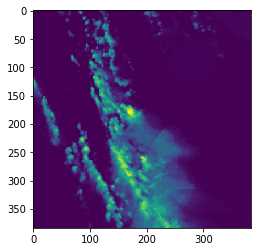

In [13]:
import os
os.environ["HDF5_USE_FILE_LOCKING"]='FALSE'  # needed on some systems
import h5py # needs conda/pip install h5py
import matplotlib.pyplot as plt

file_index = 0
SCALING_FACTOR = 1.0 # from table 3
with h5py.File('../data/vil/2018/SEVIR_VIL_STORMEVENTS_2018_0101_0630.h5','r') as hf:
    event_id = hf['id'][file_index]
    vil      = hf['vil'][file_index] * SCALING_FACTOR
    
print('Event ID:',event_id)
print('Image shape:',vil.shape)

plt.imshow(vil[:,:,20]) # plot one frame


## Accessing lightning <a class="anchor" id="lightning"></a>

TBD


## Addtional resources <a class="anchor" id="additional"></a>


* NOAA's Storm Event Database download links:  https://www.ncdc.noaa.gov/stormevents/ftp.jsp
